# Utility Notebook

The purpose of this notebook is to provide the backbone for generating reports on data synthesis quickly. This notebook will generate a range of nice looking plots comparing the real and synthetic data to use in a report.

## Utility Introduction

This paragraph can be used as a basis for an introduction to the Utility section:

In this section we present a summary of the metrics we use to measure the performance of 
our solution. They give a clear and thorough understanding of the effectiveness of our solution.
We first use a selection of metrics that measure the closeness of the Synthesized data for each column in isolation. Then we go one to look how the distribution of the columns related to one another with our interaction metrics

### Single Column Metrics
The two main metrics we use are Earth-Moving Distance and Kolmogorov-Smirnov Distance. These distances are important to us as they assume little about the form the data may take.

- **Earth-Moving distance (EMD)** is used for columns with a small number of unique values, this discrete metric makes few assumptions and takes into account the distance between values. Which some other discrete measures of distance (like Histogram Similarity) may not do
- **Kolmogorov-Smirnov Distance (KSD)** is used otherwise, this metric tends to be used for continuous inputs. It makes few assumptions about the shape of the true data and 
is part of a common non-parametric statistical test.

Both these values vary between 0 and 1, with 0 denoting an exact match and 1 denoting 
a completely different distribution.  

We also provide p-values for a two-sided test using these metrics: the standard KS statistical test provides a p-value, we use a perumation test for EMD.

### Interaction Metrics
These values are a simple basic test for the Synthesized data, it is also essential to compare the interactions between each column to ensure that the full distribution of the original data has been learnt. To compare the association between categorical variables we use the Cramér's V metric, 
to compare the continuous variables we use the Kendell Tau rank correlation coefficient. To look 
at the compare how categorical and continuous values related we consider the pseudo R2 value 
of a logistic regression model trained on the dataset

- **The Kendall-Tau Rank Correlation Coefficient** is a non parametric measurement of ordered data that detects when columns exhibit associations.
- **Cramér's V**  is a measurement between 0 and 1 that similarly measures the association of columns. We tend to use it in cases where columns exhibit few unique values.
- The McFadden’s pseudo-R2 metric gives change in the performance of a Logistic Regressor for a continuous variable against a categorical variable. This ranges from 0 to 1 where a high value indicates a large change in performance. We refer to this as the **Categorical Logistic Regression Correlation**.

In [1]:
cd ~/git/synthesized

/Users/jamied/git/synthesized


In [2]:
import pandas as pd
import numpy as np

from synthesized.testing import Assessor
from synthesized.metadata_new import MetaExtractor
from synthesized.metadata_new.base import DiscreteModel, ContinuousModel
from synthesized import HighDimSynthesizer
from synthesized.metadata_new.model import ModelFactory
from synthesized.insight.metrics import kendell_tau_correlation, cramers_v, \
                                    kolmogorov_smirnov_distance, \
                                    earth_movers_distance, \
                                    categorical_logistic_correlation
from synthesized.insight.metrics import predictive_modelling_score, predictive_modelling_comparison
from synthesized.config import ModelFactoryConfig


Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3231-2D31-322D-B531
Expires at: 2021-12-31 00:00:00


### Load data

Use the cell below to input the real and Synthesized data into the notebook 

In [20]:
# path to csv (edit this line with the real and synthetic csv paths)
df = pd.read_csv("data/credit.csv", index_col=0, nrows=10000)

df_synth = pd.read_csv("data/credit.csv", index_col=0, nrows=10000)

df_meta = MetaExtractor.extract(df)
model_config = ModelFactoryConfig()
df_models = ModelFactory(config=model_config).create_model(df_meta)

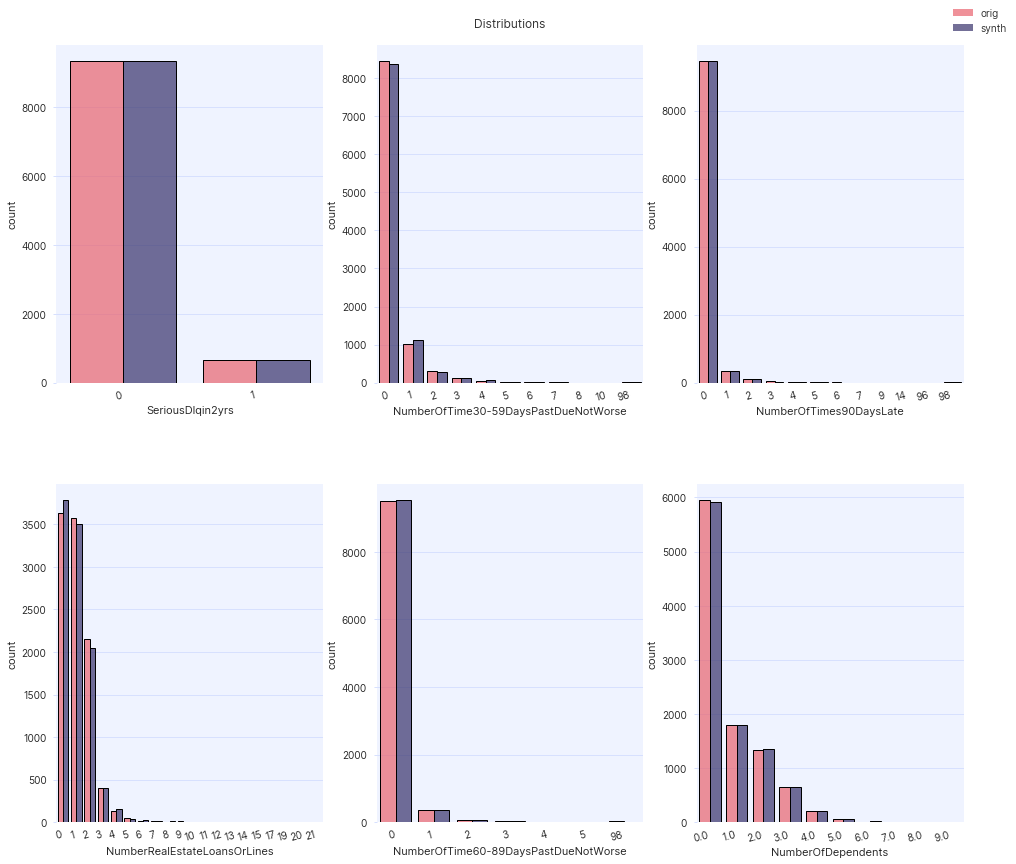

In [11]:
categorical = [model.name for model in df_models.values() if isinstance(model, DiscreteModel)]
continuous = [model.name for model in df_models.values() if isinstance(model, ContinuousModel)]

categorical_df = df[categorical]
categorical_df_synth = df_synth[categorical]

categorical_df_meta = MetaExtractor.extract(categorical_df)
assessor = Assessor(categorical_df_meta, categorical_df, categorical_df_synth)
assessor.show_distributions(cols=3)

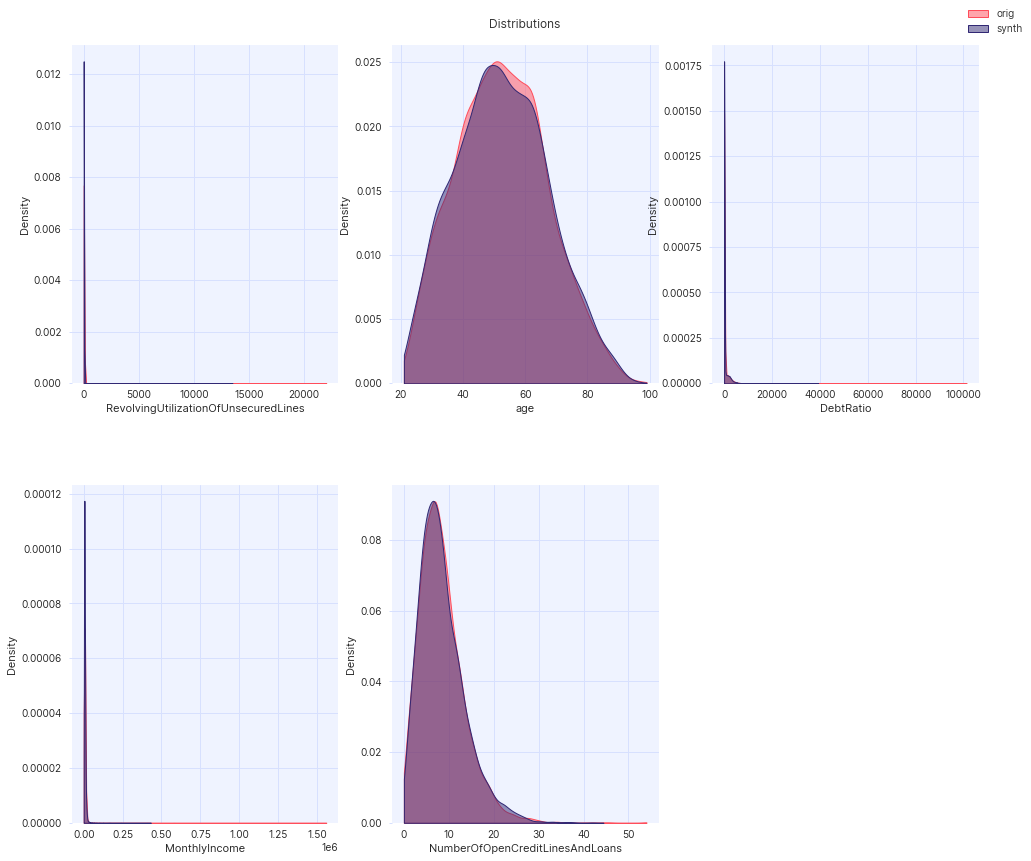

In [12]:
continuous = [model.name for model in df_models.values() if isinstance(model, ContinuousModel)]

continuous_df = df[continuous]
continuous_df_synth = df_synth[continuous]

continuous_df_meta = MetaExtractor.extract(continuous_df)
assessor = Assessor(continuous_df_meta, continuous_df, continuous_df_synth)
assessor.show_distributions(cols=3)

In [21]:
assessor = Assessor(df_meta, df, df_synth)


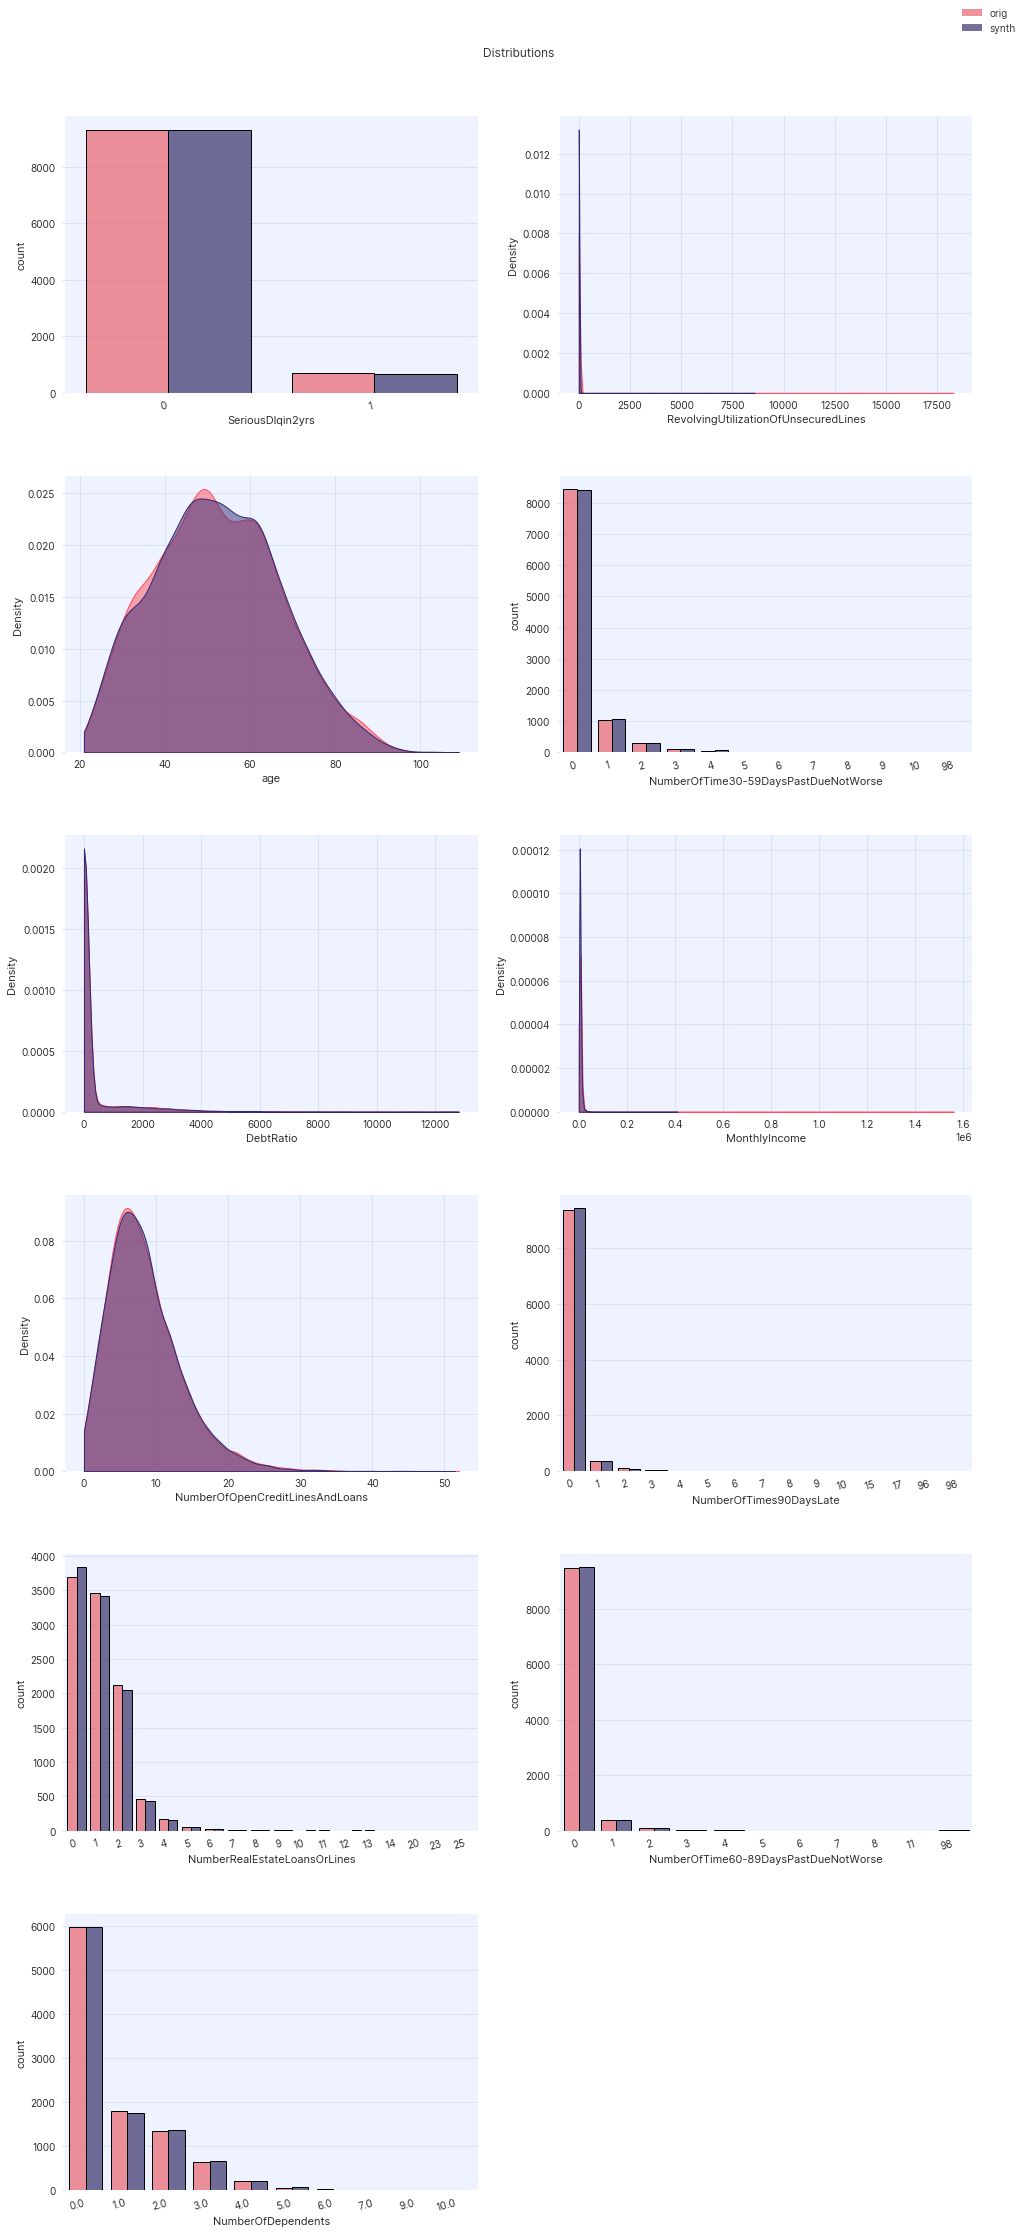

In [14]:
assessor.show_distributions()

Max kolmogorov_smirnov_distance: 0.0
Average kolmogorov_smirnov_distance distance: 0.0


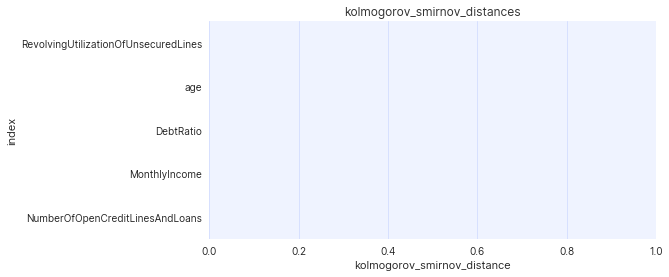

Max earth_movers_distance: 0.0
Average earth_movers_distance distance: 0.0


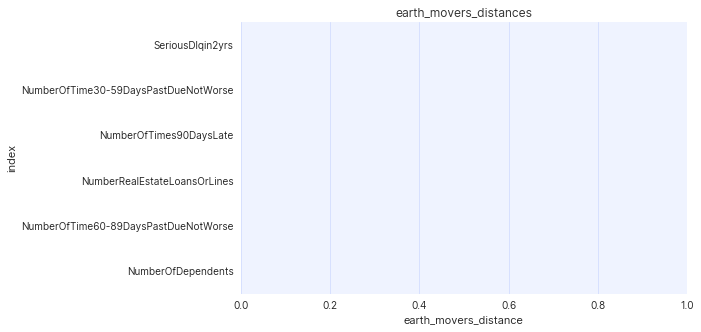

(0.0, 0.0)

In [15]:
assessor.show_first_order_metric_distances(kolmogorov_smirnov_distance)
assessor.show_first_order_metric_distances(earth_movers_distance)

In [16]:
# Generating p-values
from synthesized.insight.metrics.distance import EarthMoversDistanceBinned, KolmogorovSmirnovDistance
for ct in categorical:
    a, b = df[ct].value_counts(sort=False).sort_index(), df_synth[ct].value_counts(sort=False).sort_index()
    assert (a.index == b.index).all(), f"Failed for {ct}"
    emd = EarthMoversDistanceBinned(a, b)
    print(f'{ct}, emd, {round(emd.distance, 3)}, {round(emd.p_value, 3)}')
for cn in continuous:
    a, b = df[cn], df_synth[cn]
    ks = KolmogorovSmirnovDistance(a, b)
    print(f'{cn}, ks, {round(ks.distance, 3)}, {round(ks.p_value, 3)}')

SeriousDlqin2yrs, emd, 0.0, 1.0
NumberOfTime30-59DaysPastDueNotWorse, emd, 0.0, 1.0
NumberOfTimes90DaysLate, emd, 0.0, 1.0
NumberRealEstateLoansOrLines, emd, 0.0, 1.0
NumberOfTime60-89DaysPastDueNotWorse, emd, 0.0, 1.0
NumberOfDependents, emd, 0.0, 1.0
RevolvingUtilizationOfUnsecuredLines, ks, 0.0, 1.0
age, ks, 0.0, 1.0
DebtRatio, ks, 0.0, 1.0
MonthlyIncome, ks, 0.0, 1.0
NumberOfOpenCreditLinesAndLoans, ks, 0.0, 1.0


Max cramers_v: 0.0
Average cramers_v: 0.0


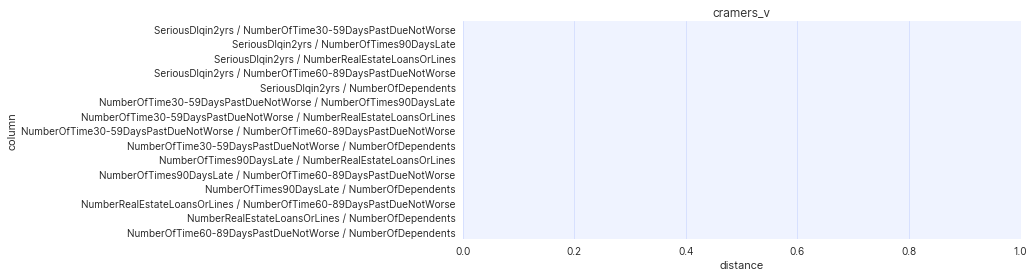

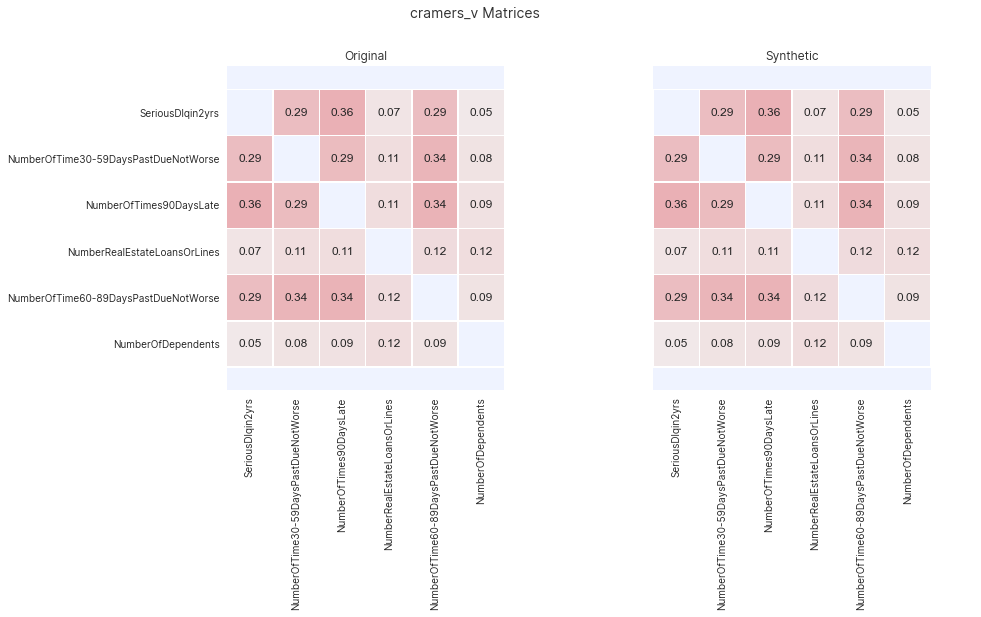

In [17]:
assessor.show_second_order_metric_distances(cramers_v)
assessor.show_second_order_metric_matrices(cramers_v)

Max kendell_tau_correlation: 0.0
Average kendell_tau_correlation: 0.0


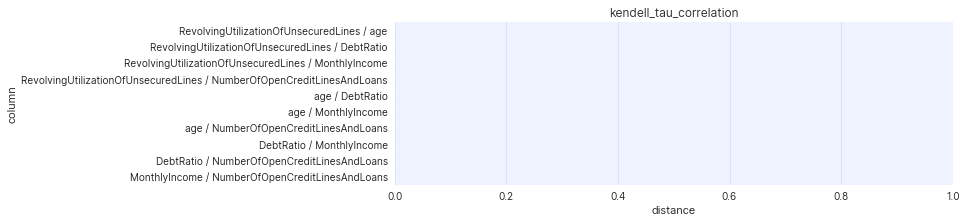

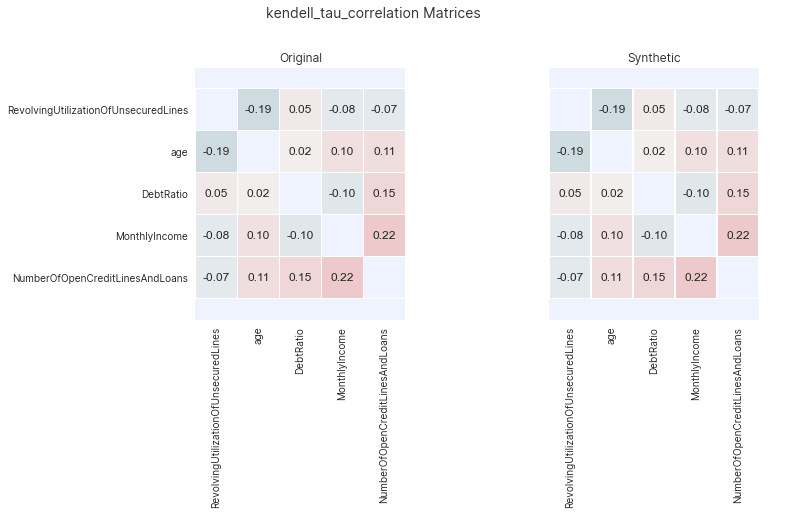

In [22]:
assessor.show_second_order_metric_distances(kendell_tau_correlation)
assessor.show_second_order_metric_matrices(kendell_tau_correlation)

Max categorical_logistic_correlation: 4.6566128730773926e-09
Average categorical_logistic_correlation: 5.893525667488575e-10


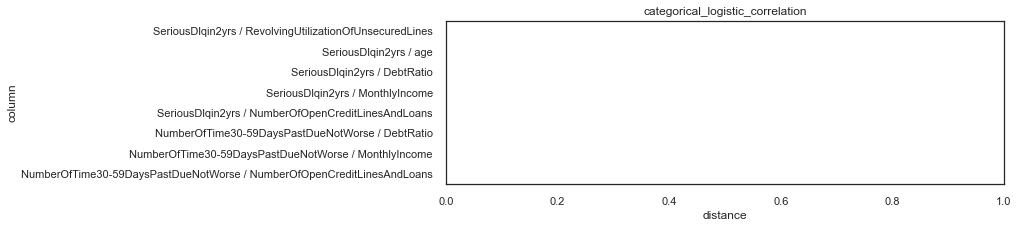

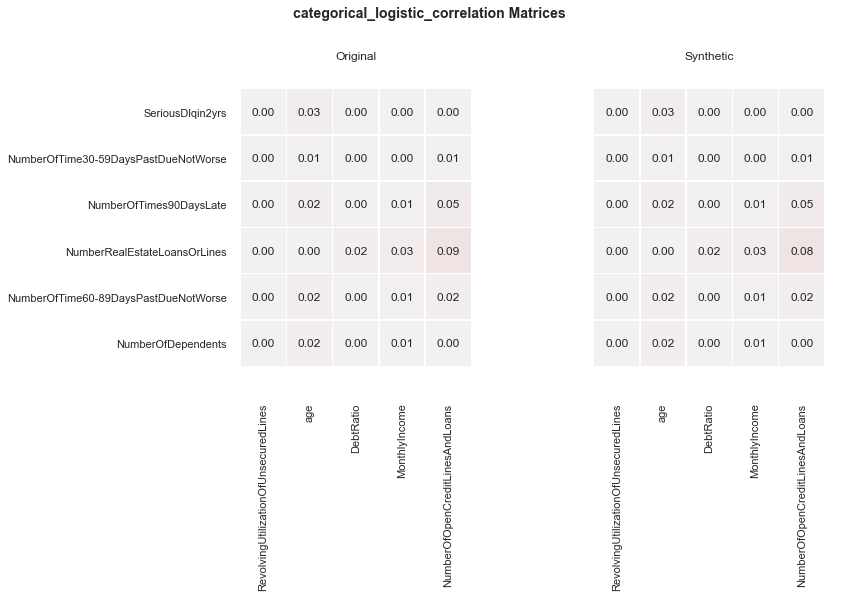

In [23]:
assessor.show_second_order_metric_distances(categorical_logistic_correlation)
assessor.show_second_order_metric_matrices(categorical_logistic_correlation)

In [24]:
y_label="SeriousDlqin2yrs"
x_labels = None

In [26]:
for model in ["Linear", "RandomForest", "GradientBoosting", "MLP"]:
    real_result, synth_result, _, _ = predictive_modelling_comparison(df, 
                                          df_synth, 
                                          y_label=y_label, 
                                          x_labels=x_labels, model=model)
    print(f"real_result: {real_result}, synth_result: {synth_result}")

real_result: 0.5261752136752137, synth_result: 0.5261752136752137
real_result: 0.8177709334935898, synth_result: 0.8198534321581197
real_result: 0.8338550013354701, synth_result: 0.834072015224359
real_result: 0.7337364783653846, synth_result: 0.7405974559294871
